# MML 1 - Combining Data with Polygons

This notebook shows how to open a DOORS dataset and how to work on it with a polygon from a shapefile. Also, it shows how a dedicated viewer can be started from the notebook itself.

We start by taking the snippet to open the CMEMS SST dataset from the xcube viewer:

In [1]:
from xcube.core.store import new_data_store

store = new_data_store(
    "s3",
    root="datasets",  # can also use "pyramids" here
    storage_options={
        "anon": True,
        "client_kwargs": {
            "endpoint_url": "https://doors.api.brockmann-consult.de/api/s3"
        }
    }
)
sst_dataset = store.open_data(data_id="cmems-sst-bs.zarr")

Now we can have a look at the dataset:

In [2]:
sst_dataset

<xarray.Dataset>
Dimensions:       (time: 3085, latitude: 200, longitude: 321)
Coordinates:
  * latitude      (latitude) float32 38.72 38.78 38.83 ... 48.67 48.72 48.78
  * longitude     (longitude) float32 26.38 26.42 26.48 ... 42.28 42.33 42.38
  * time          (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2024-06-11
Data variables:
    analysed_sst  (time, latitude, longitude) float32 dask.array<chunksize=(1, 200, 321), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                CF-1.4
    DSD_entry_id:               -GOS-L4HRfnd-BLK
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Scaling_Equation:           (scale_factor*data) + add_offset
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    ...                         ...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    time_coverage_end:          20240508T190000Z
    time_coverage_start:        20160101T070000Z
    title:                      CMEMS SST Black Sea
    uuid:                        
    westernmost_longitude:      26.375

As this is quite technical, we can also have a look at the images. As there are quite many, we only take every 100th one.

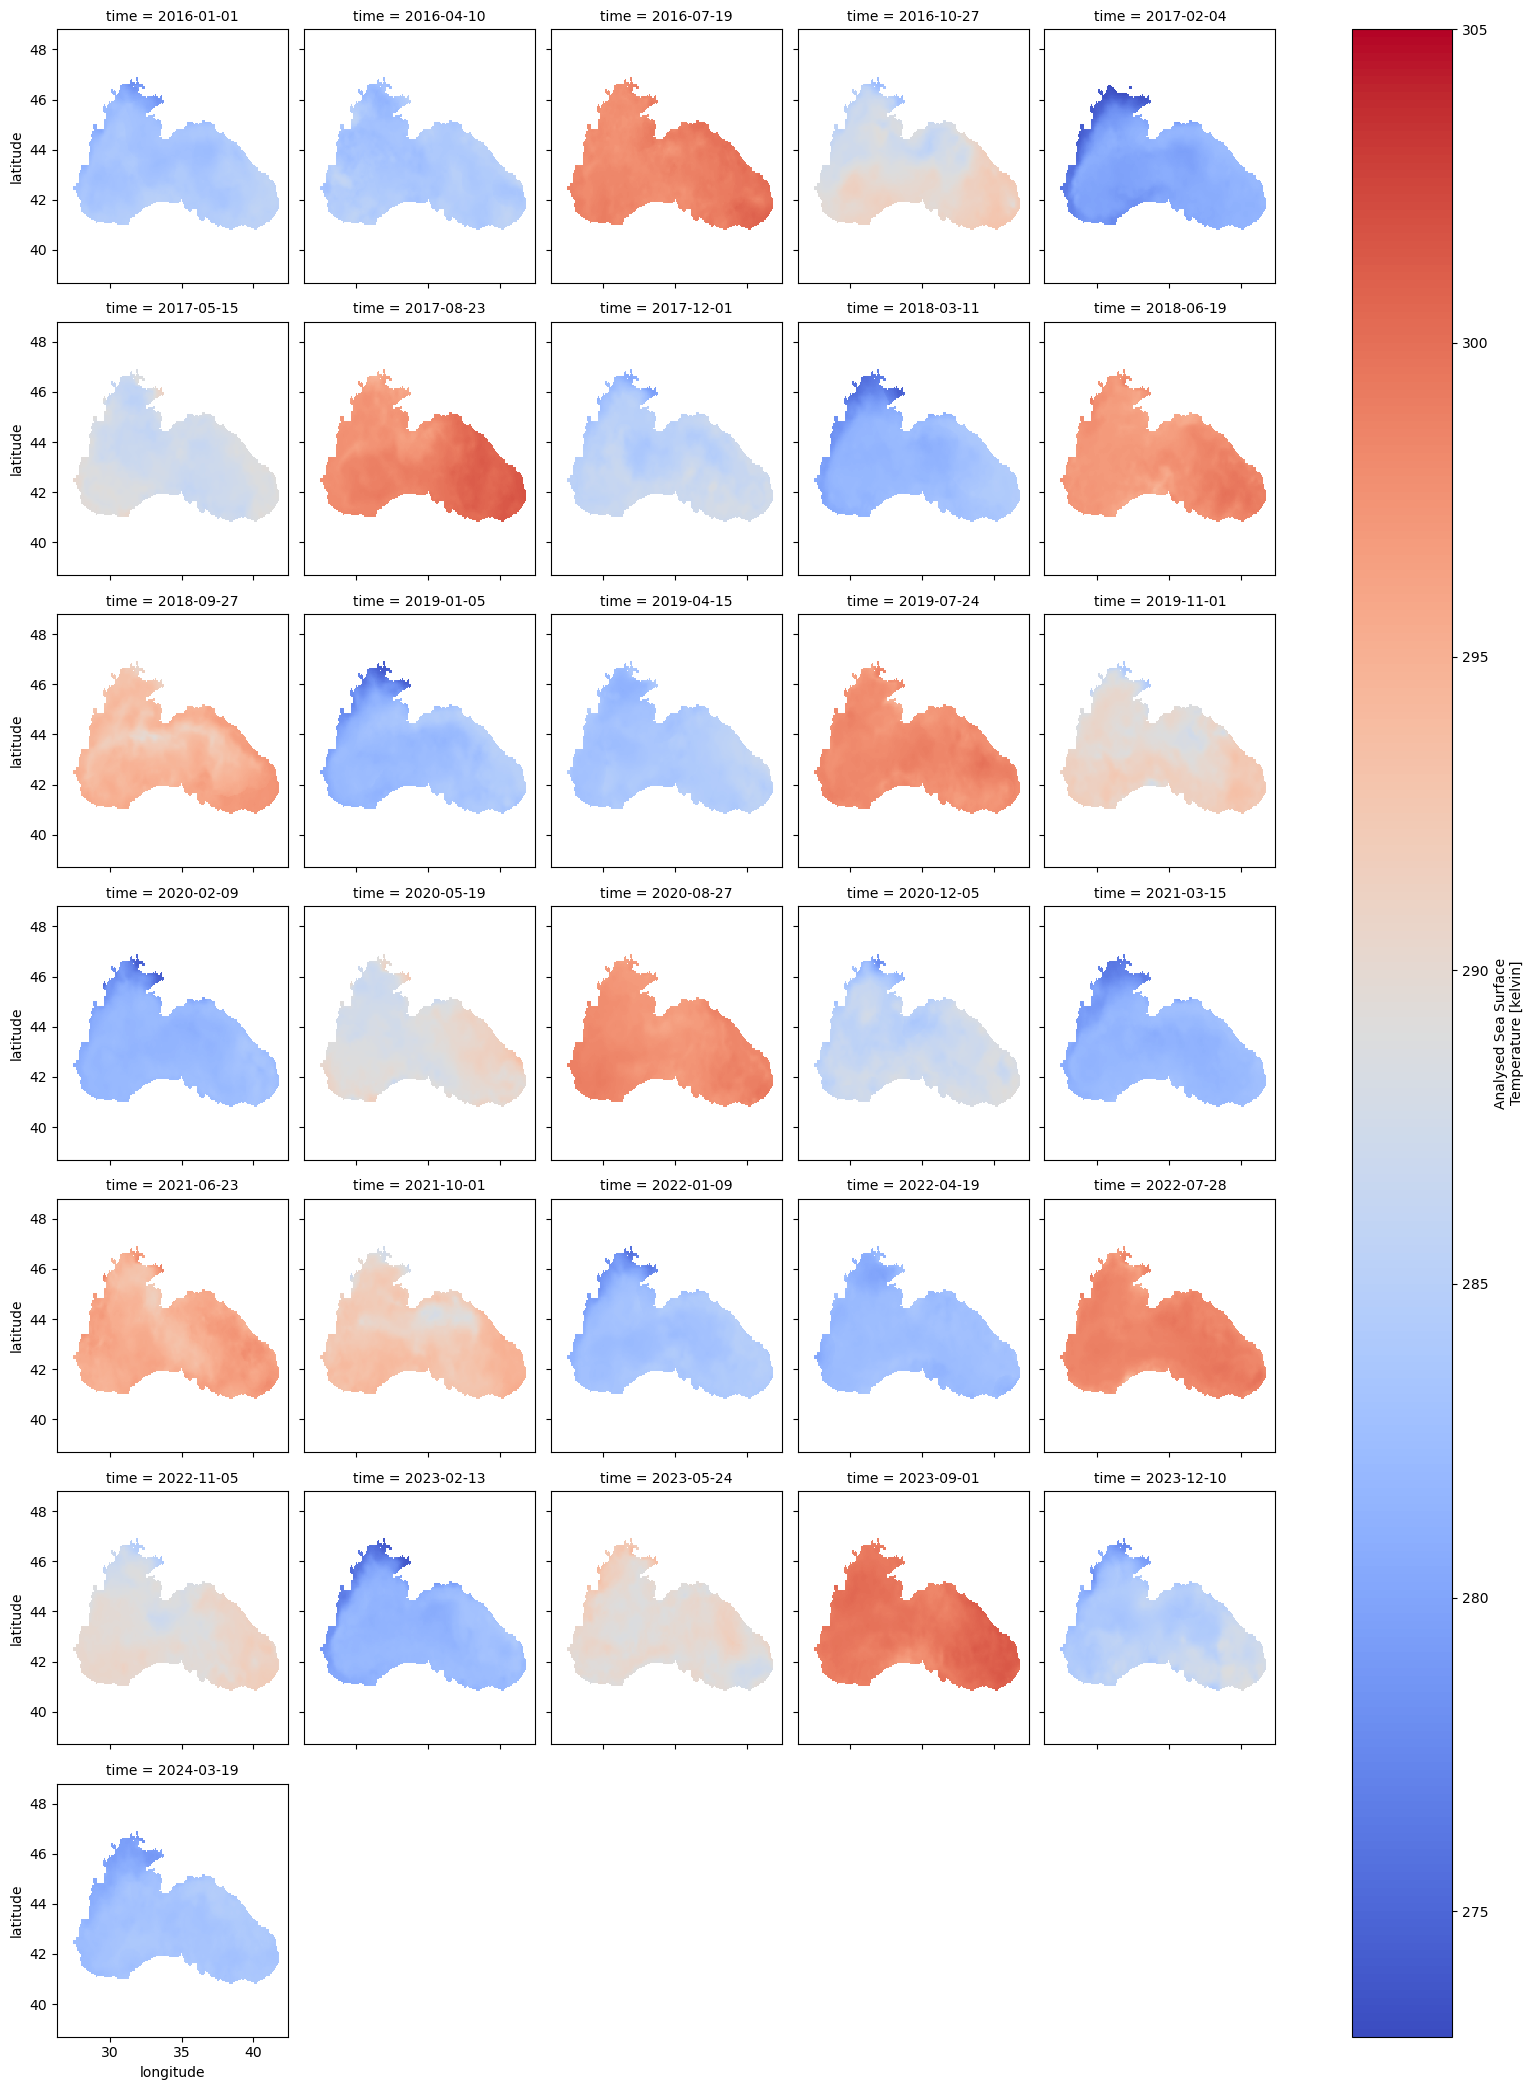

In [3]:
sst_dataset["analysed_sst"].isel(time=slice(0, 3085, 100)).plot.imshow(col="time", col_wrap=5, cmap="coolwarm", vmin=273, vmax=305)

Now, let's import some vector data. In the data folder, there is a collection of shape files to choose from. We pick an Exclusive Economic Zone and read it in as a geodataframe. But first, some necessary imports.

In [4]:
import geopandas as gpd

In [5]:
eez = gpd.read_file("geometry_data/TR_eez/TR_eez.shp")
eez

,mrgid,geoname,mrgid_ter1,pol_type,mrgid_sov1,territory1,iso_ter1,sovereign1,mrgid_ter2,mrgid_sov2,...,iso_sov1,iso_sov2,iso_sov3,un_sov1,un_sov2,un_sov3,un_ter1,un_ter2,un_ter3,geometry
0,5697,Turkish Exclusive Economic Zone,2213,200NM,2213,Turkey,TUR,Turkey,0,0,...,TUR,None,None,792.0,0.0,0.0,792.0,0.0,0.0,"POLYGON ((36.18393 43.43587, 36.84643 43.18337..."


There is only one geometry in the file, so we just extract it.

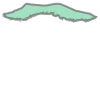

In [6]:
eez_geom = eez.geometry.iloc[0]
eez_geom

So, now we have a dataset and a polygon. What can we do with this? Well, one thing is to extract a time series. We use the `get_time_series` function from xcube for this purpose. As we are dealing with a geometry, the data is aggregated considering all values within the geometry, using a designated method. We use `mean` in our example (which is also the default), but you could also use `median`, `min`, `max`, `std` or `count`.

In [7]:
from xcube.core.timeseries import get_time_series

In [8]:
time_series = get_time_series(sst_dataset, geometry=eez_geom, agg_methods='mean')
time_series

<xarray.Dataset>
Dimensions:            (time: 3085)
Coordinates:
  * time               (time) datetime64[ns] 2016-01-01 ... 2024-06-11
Data variables:
    analysed_sst_mean  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    max_number_of_observations:  7448

Now we can plot the series (this may take a bit).

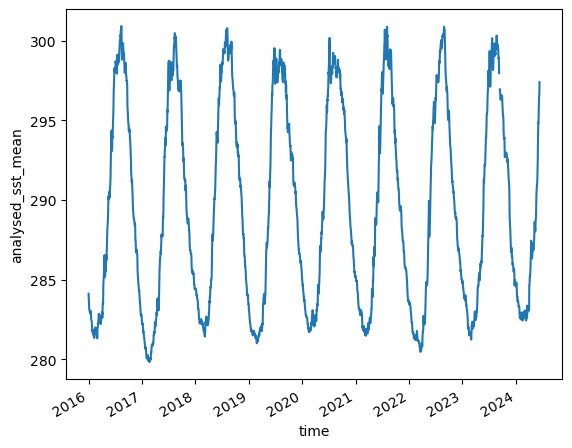

In [9]:
time_series.analysed_sst_mean.plot()

Another thing we can do is to cut out the data we are not interested in, so we only have data within the geometry.

In [10]:
from xcube.core.geom import mask_dataset_by_geometry

In [11]:
masked_ds = mask_dataset_by_geometry(sst_dataset, geometry=eez_geom)
masked_ds

<xarray.Dataset>
Dimensions:       (latitude: 52, longitude: 272, time: 3085)
Coordinates:
  * latitude      (latitude) float32 40.9 40.95 41.0 41.05 ... 43.37 43.42 43.47
  * longitude     (longitude) float32 27.98 28.02 28.08 ... 41.42 41.47 41.53
  * time          (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2024-06-11
Data variables:
    analysed_sst  (time, latitude, longitude) float32 dask.array<chunksize=(1, 52, 272), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                CF-1.4
    DSD_entry_id:               -GOS-L4HRfnd-BLK
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Scaling_Equation:           (scale_factor*data) + add_offset
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    ...                         ...
    geospatial_lon_max:         41.550001150878906
    geospatial_lat_min:         40.8713550703125
    geospatial_lat_max:         43.497488008300785
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((27.950000756469727 40.8713550703125,...
    date_modified:              2024-09-06T12:16:47.321657

Let's plot the resulting images, this time every 500th one.

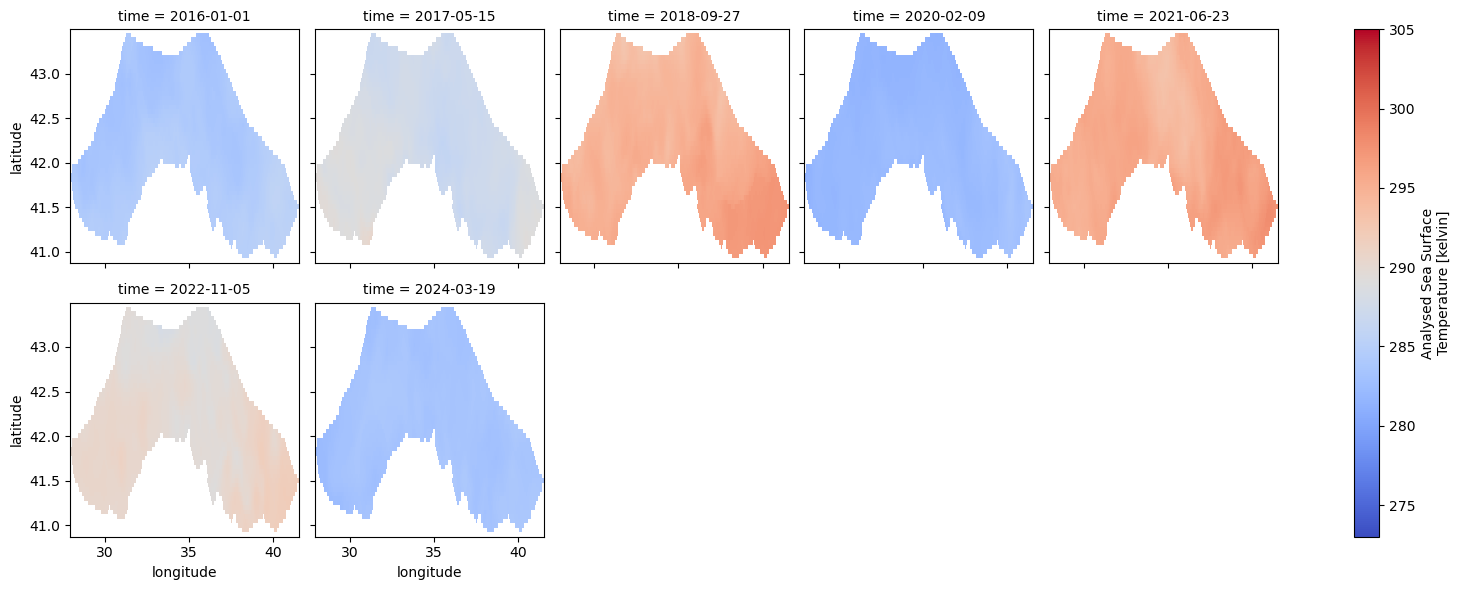

In [12]:
masked_ds["analysed_sst"].isel(time=slice(0, 3085, 500)).plot.imshow(col="time", col_wrap=5, cmap="coolwarm", vmin=273, vmax=305)

Great, we now have a new dataset. So, what can we do with it? Is there a way to view it in the viewer? Actually there is, as we can create our own viewer instance in this notebook.

In [13]:
from xcube.webapi.viewer import Viewer

In [14]:
viewer = Viewer()

There we have it. Now we can add the freshly created dataset.

In [15]:
viewer.add_dataset(masked_ds)

'827d7405-f67f-45b1-94f6-4f0b08fdd97c'

Requesting the viewer information will give us the links to the server and the viewer. If you click the viewer link, it will open in a new browser window. Alternatively, you may open the viewer in a notebook cell with the `show()` command.

In [ ]:
viewer.info()

In [ ]:
viewer.show()

And now, if you like, you may write out the file.

In [ ]:
masked_ds.to_zarr("masked_data.zarr")